In [13]:
# Data Manipulation
import pandas as pd
import numpy as np

# Text Processing and NLP
import emoji
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Machine Learning
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ngmin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load Data

In [4]:
df = pd.read_csv("00_dataset/without_stopwords/cleaned_reviews.csv")

In [5]:
df.head()

,user_id,prod_id,review_text,rating,label,cleaned_text
0,5044,0,"Drinks were bad, the hot chocolate was watered...",1.0,1,"Drinks bad , hot chocolate water latte burnt t..."
1,5045,0,This was the worst experience I've ever had a ...,1.0,1,This bad experience I ever casual coffee/light...
2,5046,0,This is located on the site of the old Spruce ...,3.0,1,This locate site old Spruce St. Video . The mi...
3,5047,0,I enjoyed coffee and breakfast twice at Toast ...,5.0,1,I enjoy coffee breakfast twice Toast recent vi...
4,5048,0,I love Toast! The food choices are fantastic -...,5.0,1,I love Toast ! The food choice fantastic - I l...


In [9]:
df["cleaned_text"] = df["cleaned_text"].fillna("")

## Data Splitting

In [10]:
X = df["cleaned_text"]
y = df["label"]

# First, split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Next, split Train (80%) into Train (70%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=42)

print("Training set: ", len(X_train))
print("Test set: ", len(X_test))
print("Validation set: ", len(X_val))

Training set:  425920
Test set:  121692
Validation set:  60846


In [11]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

Train Class Distribution:
 label
0    0.867799
1    0.132201
Name: proportion, dtype: float64

Validation Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64

Test Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64


# Feature Extraction - With Stopwords

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)  # Top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Baseline Model - With Stopwords

Baseline model no need to perform feature engineering. This will be a simple benchmark with "raw" processed data.

[Start simple](https://https://lopezyse.medium.com/your-guide-to-feature-engineering-383f7e8b7584#:~:text=Start%20simple%3A%20you%20can%20get,features%20to%20engineer%20and%20use.): you can get an excellent baseline performance by creating an initial model without deep features. After this baseline is achieved, you can try more esoteric approaches.

In [14]:
nb = MultinomialNB()

nb.fit(X_train_tfidf, y_train)

# Save the model
joblib.dump(nb, '00_dataset/without_stopwords/beforeFeatureEngineering/nb.joblib')
print("Naive Bayes training completed and saved.")

Naive Bayes training completed and saved.


Accuracy:  0.867912434671137
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     52802
           1       0.60      0.00      0.01      8044

    accuracy                           0.87     60846
   macro avg       0.73      0.50      0.47     60846
weighted avg       0.83      0.87      0.81     60846

ROC-AUC Score:  0.7145537287805597


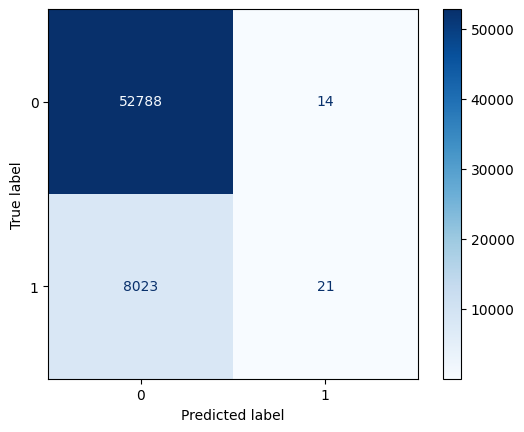

In [23]:
# Predict on val set
y_pred = nb.predict(X_val_tfidf)

# Evaluate Baseline Performance
print("Accuracy: ", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Compute ROC-AUC
yProba_nbBaseline = nb.predict_proba(X_val_tfidf)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, yProba_nbBaseline))

# Generate confusion matrix
cm_baseline = confusion_matrix(y_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

## Analysis of Baseline Model

* The model shows an accuracy of 86.8%.
* Precision for Class 1 is 0.62. This shows that when the model predicts as Spam, it is correct 62% of the time.
* ROC-AUC score of 0.718 suggests the model is somewhat distinguishing between classes.
---
* Recall for Class 1 is 0. This shows that the model is failing to detect Spam.
  <br>(Recall is crucial in imbalanced datasets)
* F1-score for class is 0. This confirms that the model is not capturing the minority class at all.


## Class imbalance handling

Class Balancing with Naive Balance: to check if doing so will improve the results

In [18]:
nb_balanced = MultinomialNB(class_prior=[0.5, 0.5]) # Giving equal weightage to both classes
nb_balanced.fit(X_train_tfidf, y_train)

# Save the model
joblib.dump(nb_balanced, '00_dataset/without_stopwords/beforeFeatureEngineering/nb_balanced.joblib')
print("Naive Bayes training completed and saved.")

Naive Bayes training completed and saved.


Accuracy:  0.647043355356145
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     52802
           1       0.22      0.67      0.33      8044

    accuracy                           0.65     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.83      0.65      0.70     60846

ROC-AUC Score:  0.7145537287805597


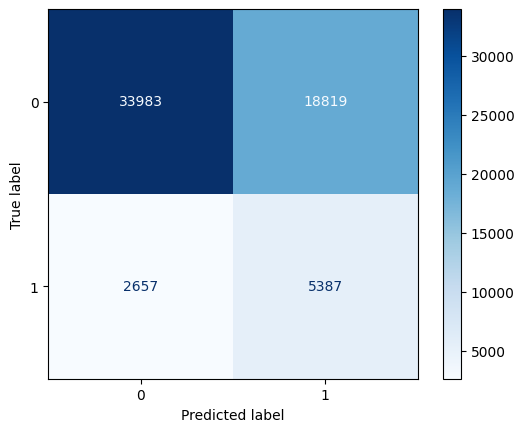

In [24]:
y_pred_balanced = nb_balanced.predict(X_val_tfidf)

# Evaluate Baseline Performance
print("Accuracy: ", accuracy_score(y_val, y_pred_balanced))
print("Classification Report:\n", classification_report(y_val, y_pred_balanced))

# Compute ROC-AUC
y_proba_balanced = nb_balanced.predict_proba(X_val_tfidf)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba_balanced))

cm_balanced = confusion_matrix(y_val, y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=[0, 1])
disp_balanced.plot(cmap="Blues")

## Apply SMOTE

In [25]:
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train Naive Bayes on resampled data
nb_smote = MultinomialNB()
nb_smote.fit(X_train_resampled, y_train_resampled)

# Save the model
joblib.dump(nb_smote, '00_dataset/without_stopwords/beforeFeatureEngineering/nb_smote.joblib')
print("Naive Bayes training completed and saved.")

# Predict using the SMOTE-trained model
y_pred_smote = nb_smote.predict(X_val_tfidf)

Naive Bayes training completed and saved.


Accuracy:  0.6530256713670578
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.65      0.77     52802
           1       0.23      0.67      0.34      8044

    accuracy                           0.65     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.83      0.65      0.71     60846

ROC-AUC Score:  0.7163941613048992


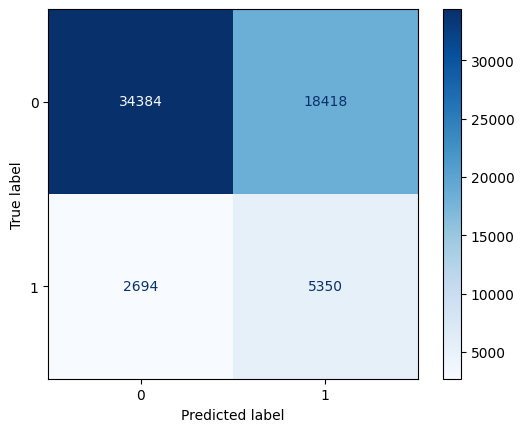

In [26]:
# Evaluate Baseline Performance
print("Accuracy: ", accuracy_score(y_val, y_pred_smote))
print("Classification Report:\n", classification_report(y_val, y_pred_smote))

# Compute ROC-AUC
y_proba_smote = nb_smote.predict_proba(X_val_tfidf)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba_smote))

cm_smote = confusion_matrix(y_val, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=[0, 1])
disp_smote.plot(cmap="Blues")

## Baseline Model Performance Comparison - Naive Bayes

| Model Version  | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | ROC-AUC Score |
|---------------|----------|--------------------|-----------------|-----------------|---------------|
| **Initial Baseline** | 86.8% | 62% | 0%  | 0%  | 0.718 |
| **Balanced Classes** | 64.8% | 22% | 68% | 34% | 0.718 |
| **SMOTE** | 65.7% | 23% | 67% | 34% | 0.719 |



# Feature Engineering

[**Feature engineering**](https://medium.com/data-and-beyond/a-step-to-step-guide-for-feature-engineering-over-textual-data-nlp-a54c53081e04) is the process of selecting and creating the most relevant and useful features to input into a machine learning model. It is a crucial step in the machine learning process that can significantly impact the model’s performance, complexity, and ability to generalize to new data. By carefully selecting and constructing the features used as input, it is possible to improve the accuracy and effectiveness of the model and avoid overfitting.


1. Length of Tweet
  
  The length of the tweet (in characters) can be a useful feature, as longer tweets may contain more information than shorter tweets. We can extract the length of the tweet like this:
  ```
  def get_length(text):
    return len(text)
  ```

2. Number of Exclamation Points

  The number of exclamation points in a tweet can be a useful feature, as it may indicate the intensity or emotion of the tweet. We can extract the number of exclamation points like this:
  ```
  def get_exclamation_count(text):
    return text.count('!')
  ```
3. Number of Question Marks

  Similar to exclamation points, the number of question marks in a tweet can be a useful feature. We can extract the number of question marks like this:
  ```
  def get_question_mark_count(text):
    return text.count('?')
  ```
4. Sentiment

  The sentiment of a tweet (i.e., whether it is positive, negative, or neutral) can be a useful feature for tasks such as sentiment analysis. We can use a sentiment analysis tool to extract the sentiment of a tweet. One such tool is SentiStrength, which can be used in Python like this:

  ```
  import sentistrength

  def get_sentiment(text):
    sentiment = sentistrength.analyze(text)[0]
    return sentiment
  ```

5. Named Entities

  Named entities are specific people, organizations, locations, etc. that are mentioned in a tweet. We can use a named entity recognition tool to extract the named entities from a tweet. Here’s an example using spaCy:

  ```
  import spacy

  # Load spaCy model
  nlp = spacy.load('en_core_web_sm')

  def get_named_entities(text):
    doc = nlp(text)
    named_entities = [X.text for X in doc.ents]
    return named_entities
  ```

6. Emoji

  Emojis can convey emotion and sentiment in a tweet, and can therefore be a useful feature. We can use the emoji library to extract the emoji from a tweet like this:

  ```
  import emoji

  def get_emojis(text):
    emojis = [emoji.emojize(word) for word in text.split()]
    emojis = [emoji for emoji in emojis if emoji != word]
    return emojis
  ```

7. URL (Already removed in cleaned text)

  If a tweet contains a URL, it can be a useful feature for tasks such as topic classification or web scraping. We can extract the URL from a tweet using a regular expression like this:

  ```
  def get_url(text):
    url = re.findall(r'https?://\S+', text)
    return url
  ```

8. Word Count

  The word count of a tweet can be a useful feature, as it may give us an indication of the complexity or length of the tweet. We can get the word count like this:

  ```
  def get_word_count(text):
    return len(text.split())
  ```

9. Average Word Length

  The average length of the words in a tweet can be a useful feature. We can compute the average word length like this:

  ```
  def get_avg_word_length(text):
    words = text.split()
    word_count = len(words)
    avg_word_length = sum(len(word) for word in words) / word_count
    return avg_word_length
```
10. Capitalized Words

  Words that are capitalized in a tweet may be more important or relevant than lowercase words. We can extract the capitalized words from a tweet like this:

  ```
  def get_capitalized_words(text):
    capitalized_words = [word for word in text.split() if word.isupper()]
    return capitalized_words
```



In [ ]:
sia = SentimentIntensityAnalyzer()

def extract_features(text):
    sentiment_score = TextBlob(text).sentiment.polarity  # Sentiment (-1 to +1)
    vader_score = sia.polarity_scores(text)["compound"]  # VADER sentiment
    review_length = len(text.split())  # Word count
    exclamation_count = text.count("!")  # Number of !
    question_count = text.count("?")  # Number of ?
    uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0  # % uppercase
    duplicate_word_count = len([w for w in text.split() if text.split().count(w) > 1])  # Repeated words
    emoji_count = len([char for char in text if char in emoji.EMOJI_DATA])  # Count emojis
    avg_word_length = sum(len(word) for word in text.split()) / review_length if review_length > 0 else 0  # Avg word length

    return [sentiment_score, vader_score, review_length, exclamation_count, question_count, uppercase_ratio,
            duplicate_word_count, emoji_count, avg_word_length]

In [ ]:
# Apply feature extraction to dataset
df_train_features = X_train.apply(extract_features)
df_test_features = X_test.apply(extract_features)
df_val_features = X_val.apply(extract_features)

features_cols = ["sentiment_score", "vader_score", "review_length",
                 "exclamation_count", "question_count", "uppercase_ratio",
                 "duplicate_word_count", "emoji_count", "avg_word_length"]

df_train_features = pd.DataFrame(df_train_features.tolist(), columns=features_cols)
df_test_features = pd.DataFrame(df_test_features.tolist(), columns=features_cols)
df_val_features = pd.DataFrame(df_val_features.tolist(), columns=features_cols)

In [ ]:
# Convert sparse TF-IDF matrix to dense NumPy array
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()

# Convert TF-IDF dense matrix to DataFrame
df_train_tfidf = pd.DataFrame(X_train_tfidf_dense)
df_test_tfidf = pd.DataFrame(X_test_tfidf_dense)
df_val_tfidf = pd.DataFrame(X_val_tfidf_dense)

# **Check if row counts match before merging**
assert df_train_tfidf.shape[0] == df_train_features.shape[0], "Mismatch in train set sizes!"
assert df_test_tfidf.shape[0] == df_test_features.shape[0], "Mismatch in test set sizes!"
assert df_val_tfidf.shape[0] == df_val_features.shape[0], "Mismatch in validation set sizes!"

In [ ]:
# Reset indices for training set
df_train_tfidf.reset_index(drop=True, inplace=True)
df_train_features.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Reset indices for testing set
df_test_tfidf.reset_index(drop=True, inplace=True)
df_test_features.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Reset indices for validation set
df_val_tfidf.reset_index(drop=True, inplace=True)
df_val_features.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [ ]:
df_y_train = pd.DataFrame(y_train, columns=["label"])
df_y_test = pd.DataFrame(y_test, columns=["label"])
df_y_val = pd.DataFrame(y_val, columns=["label"])

# Check if the row counts of y labels match the features before merging
assert df_train_tfidf.shape[0] == df_y_train.shape[0], "Mismatch in train labels!"
assert df_test_tfidf.shape[0] == df_y_test.shape[0], "Mismatch in test labels!"
assert df_val_tfidf.shape[0] == df_y_val.shape[0], "Mismatch in validation labels!"

# Check if indices match
print(df_train_tfidf.index.equals(df_y_train.index))  # Should be True
print(df_test_tfidf.index.equals(df_test_features.index))    # Should be True
print(df_val_tfidf.index.equals(df_y_val.index))      # Should be True

In [ ]:
# Check if indices match
print(df_train_tfidf.index.equals(df_train_features.index))  # Should be True
print(df_test_tfidf.index.equals(df_y_test.index))    # Should be True
print(df_val_tfidf.index.equals(df_val_features.index))      # Should be True

In [ ]:
df_y_val.head()

In [ ]:
# Merge TF-IDF with extracted features
df_train_combined = pd.concat([df_train_tfidf, df_train_features, df_y_train], axis=1)
df_test_combined = pd.concat([df_test_tfidf, df_test_features, df_y_test], axis=1)
df_val_combined = pd.concat([df_val_tfidf, df_val_features, df_y_val], axis=1)

In [ ]:
print("NaN values in train set:\n", df_train_combined.isna().sum())
print("NaN values in test set:\n", df_test_combined.isna().sum())
print("NaN values in validation set:\n", df_val_combined.isna().sum())

In [ ]:
df_train_combined.head()
df_test_combined.head()
df_val_combined.head()

In [ ]:
df_train_combined.to_csv("00_dataset/with_stopwords/train_features_sw.csv", index=False)
df_test_combined.to_csv("00_dataset/with_stopwords/test_features_sw.csv", index=False)
df_val_combined.to_csv("00_dataset/with_stopwords/val_features_sw.csv", index=False)

print("Features saved successfully to CSV!")